In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.__version__

'1.4.1'

In [29]:
pip install --upgrade pandas

  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
Note: you may need to restart the kernel to use updated packages.


# Data Pre-processing

In [9]:
# all_train = pd.read_csv("datasets/toxic_train.csv")

In [10]:
# filter only toxic comments and convert comment_text to str

# toxic_only_train = all_train[all_train["target"] >= 0.5]
# toxic_only_train['comment_text'] = toxic_only_train['comment_text'].astype(str)

In [11]:
# shortlist only columns of interest only as well

# temp = toxic_only_train.iloc[:, :-13]
# toxic_only_train_shortlisted = temp.drop(temp.columns[[0, 1, 3, 4, 5, 6, 7]], axis = 1)
# toxic_only_train_shortlisted.head()

In [12]:
# assuming that if NaN for any category, probability of category = 0

# toxic_only_train_shortlisted.fillna(0, inplace = True)
# toxic_only_train_shortlisted.head()

In [13]:
# sum values for race, gender, religion and disabilities

# toxic_only_train_shortlisted["Race"] = toxic_only_train_shortlisted[["black", "white", "asian", "latino", "other_race_or_ethnicity"]].sum(axis = 1)
# toxic_only_train_shortlisted["Gender"] = toxic_only_train_shortlisted[["male", "female", "transgender", "other_gender", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "other_sexual_orientation"]].sum(axis = 1)
# toxic_only_train_shortlisted["Religion"] = toxic_only_train_shortlisted[["christian", "jewish", "muslim", "hindu", "atheist", "other_religion"]].sum(axis = 1)
# toxic_only_train_shortlisted["Disability"] = toxic_only_train_shortlisted[["intellectual_or_learning_disability", "other_disability", "physical_disability", "psychiatric_or_mental_illness"]].sum(axis = 1)

In [14]:
# drop identity columns after

# toxic_only_train_shortlisted.drop(toxic_only_train_shortlisted.iloc[:, 1:25], inplace = True, axis = 1)

In [15]:
# if all identities are 0, we will assume that attacks were not directed to any in particular and hence "None"

# toxic_only_train_shortlisted["target"] = np.where(toxic_only_train_shortlisted.iloc[:, 1:5].max(axis = 1) > 0, toxic_only_train_shortlisted.iloc[:, 1:5].idxmax(axis = 1), "None")

In [16]:
# drop sum columns for all identities

# toxic_only_train_shortlisted.drop(toxic_only_train_shortlisted.iloc[:, 1:5], inplace = True, axis = 1)

In [3]:
# preprocess text
# keep asterisks as they may be used to censor vulgar words

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re

# nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocesstext(text):
    text = text.lower() # convert everything to lower case first
    text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations
    words = word_tokenize(text)
    words_without_stopwords = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    text = " ".join(words_without_stopwords)
    return text

In [18]:
# toxic_only_train_shortlisted["preprocessed_text"] = toxic_only_train_shortlisted["comment_text"].apply(preprocesstext)

In [19]:
# save files so that there's no need to preprocess again

# toxic_only_train_shortlisted.to_pickle('toxic_only_train_shortlisted_preprocessed.pkl')

In [4]:
# load preprocessed file

toxic_only_train_shortlisted = pd.read_pickle('./toxic_only_train_shortlisted_preprocessed.pkl')

In [220]:
toxic_only_train_shortlisted

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comment_text,target,preprocessed_text
4,haha you guys are a bunch of losers.,Disability,haha guy bunch loser
5,ur a sh*tty comment.,None,ur sh * tty comment
13,It's ridiculous that these guys are being call...,None,ridiculous guy called protester armed threat v...
14,This story gets more ridiculous by the hour! A...,None,story get ridiculous hour love people sending ...
19,"Angry trolls, misogynists and Racists"", oh my....",None,angry troll misogynist racist oh take 150 iq s...
...,...,...,...
1804825,Who is the jerk in the last row between the C ...,None,jerk last row c e
1804838,Nobody really cares that she supports the scie...,None,nobody really care support science behind glob...
1804856,Believing in God or not believing in God are p...,Religion,believing god believing god position held mill...
1804857,"I take your point, but I think you're shooting...",None,take point think shooting messenger police enf...


# Classification Models (Task 1)

In [5]:
from sklearn.model_selection import train_test_split

X = toxic_only_train_shortlisted["preprocessed_text"]
y = toxic_only_train_shortlisted["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)

In [16]:
# install yellowbrick for AUC ROC plot for multiclass

# !pip install yellowbrick

In [13]:
# for evaluation of performance

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [14]:
# to facilitate the plotting of ROCAUC curve

from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, classes=['Race', 'Gender', 'Religion', 'Disability', 'None'])
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

**Logistic Regression**

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
logreg = LogisticRegression(C = 5, random_state = 42, solver = 'sag', max_iter = 1000, n_jobs = -1)
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)

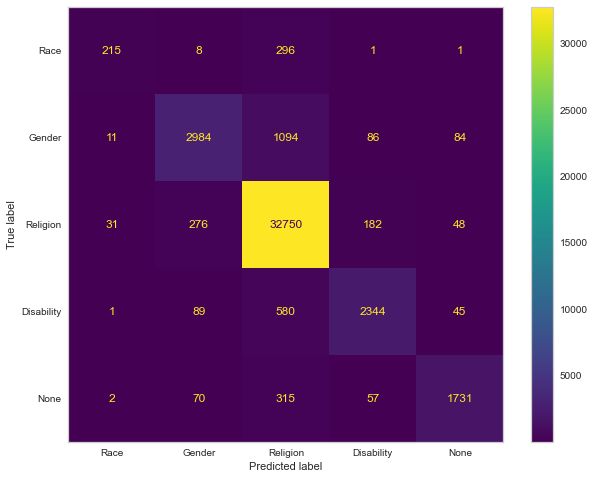

In [17]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Race", "Gender", "Religion", "Disability", "None"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Disability       0.83      0.41      0.55       521
      Gender       0.87      0.70      0.78      4259
        None       0.93      0.98      0.96     33287
        Race       0.88      0.77      0.82      3059
    Religion       0.91      0.80      0.85      2175

    accuracy                           0.92     43301
   macro avg       0.88      0.73      0.79     43301
weighted avg       0.92      0.92      0.92     43301



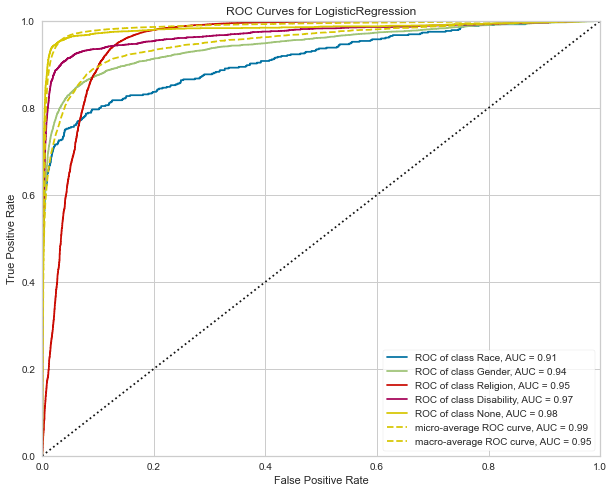

In [19]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(logreg, tfidf_train, y_train, tfidf_test, y_test)
plt.show()

**LSTM**

In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
X_test.to_numpy()

array(['crock deluded * would highly recommend person get hospital stat head removed buttock religious war islam islam even hatred israel america unite',
       'damned pleb told anymore merkel right need censor social medium give controlled view world start picking migrant libyan coast bringing italy really wonderful like anyone say jail cell',
       'serious mental illness look like paramilitary militia sovereign citizen sociopathic paranoic delusional criminal hysteria contagious degree armed dangerous',
       ...,
       'nanny state start child state know better idiot parent absolutely business municipal government employee elected official much cheer',
       'nothing near revolting south african',
       'man stand defend insult slander family child really man left really set tone called trump orange son feeble wife prostitute'],
      dtype=object)

In [55]:
train_sentence = []
for row in X_train.to_numpy():
    train_sentence.append(row)
train_sentence

['god best god fact god god ridiculous made rubbish though real know majority faith based follower even know history thier religion follow blindly look america headed back dark age',
 'ummm aware david sexually assaulted wife one loyal soldier turned pregnant soldier murdered conceal crime 2 samuel 11',
 'yep misogynistic sexist conservative fool',
 'wow know piece trivia mccain voted opening anwr wonder never came 2008 campaign course sarah palin ticket state would gone republican matter alaskan figure sarah truly idiot much later',
 'christianity different crusader slaughtered jew medieval era germany really christian spanish inquisition official executioner really christian protestant roman catholic bombed shot committed violence northern ireland really christian member kkk really christian yes heard argument sadly',
 'soft letting suit ruin life miserable system failed trying catch stain left monetary system oh well crappy unis wont fix problem fix nothing occupy movement soft guy 

In [56]:
test_sentence = []
for row in X_test.to_numpy():
    test_sentence.append(row)
test_sentence

['crock deluded * would highly recommend person get hospital stat head removed buttock religious war islam islam even hatred israel america unite',
 'damned pleb told anymore merkel right need censor social medium give controlled view world start picking migrant libyan coast bringing italy really wonderful like anyone say jail cell',
 'serious mental illness look like paramilitary militia sovereign citizen sociopathic paranoic delusional criminal hysteria contagious degree armed dangerous',
 'black fox news host receives death threat daring criticize trump fox like think williams little concerned dog lie fox gotten flea',
 'good old socialistic mother put bottled water folk business lose job import state another reason nutter must voted',
 'common sense untold thousand unemployed skilled trade people across canada think allowing canada compete job come good policy man canada doomed stupidity',
 'propaganda anti prostitutionist surprise really care would supporting passing hb112 make fe

In [59]:
max_words = 30000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentence)
sequences = tok.texts_to_sequences(train_sentence)
X_train_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
# oversample = SMOTE()
X_train_sequences_matrix

array([[    0,     0,     0, ...,    47,  1502,   700],
       [    0,     0,     0, ...,   223, 14765,  1122],
       [    0,     0,     0, ...,  1049,   183,    75],
       ...,
       [    0,     0,     0, ...,   516,  2428, 22891],
       [    0,     0,     0, ...,    84,    88,  1118],
       [    0,     0,     0, ...,   343,   127,  1174]])

In [60]:
tok.fit_on_texts(test_sentence)
sequences = tok.texts_to_sequences(test_sentence)
X_test_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_test_sequences_matrix

array([[   0,    0,    0, ...,  894,   82, 4260],
       [   0,    0,    0, ...,   20,  581, 2191],
       [   0,    0,    0, ..., 1229, 1443,  558],
       ...,
       [   0,    0,    0, ...,  899,   40, 3075],
       [   0,    0,    0, ..., 6010,  674, 1025],
       [   0,    0,    0, ..., 4683,  506, 2239]])

In [107]:
X_train_sequences_matrix.shape[0]

101033

In [106]:
y_train_2.shape

(101033, 5)

In [ ]:
# ["Race", "Gender", "Religion", "Disability", "None"]

In [124]:
y_train_2 = []
for i in y_train.to_numpy():
    if i=="Race":
        y_train_2.append([1,0,0,0,0])
    elif i=="Gender":
        y_train_2.append([0,1,0,0,0])
    elif i=="Religion":
        y_train_2.append([0,0,1,0,0])
    elif i=="Disability":
        y_train_2.append([0,0,0,1,0])
    else:
        y_train_2.append([0,0,0,0,1])
y_train_2 = np.array(y_train_2)

In [144]:
y_train_3 = []
for i in y_train.to_numpy():
    if i=="Race":
        y_train_3.append(1)
    elif i=="Gender":
        y_train_3.append(2)
    elif i=="Religion":
        y_train_3.append(3)
    elif i=="Disability":
        y_train_3.append(4)
    else:
        y_train_3.append(5)
y_train_3 = np.array(y_train_3)

In [182]:
y_test_2 = []
for i in y_test.to_numpy():
    if i=="Race":
        y_test_2.append([1,0,0,0,0])
    elif i=="Gender":
        y_test_2.append([0,1,0,0,0])
    elif i=="Religion":
        y_test_2.append([0,0,1,0,0])
    elif i=="Disability":
        y_test_2.append([0,0,0,1,0])
    else:
        y_test_2.append([0,0,0,0,1])
y_test_2 = np.array(y_test_2)

In [140]:
y_test_3 = []
for i in y_test.to_numpy():
    if i=="Race":
        y_test_3.append(1)
    elif i=="Gender":
        y_test_3.append(2)
    elif i=="Religion":
        y_test_3.append(3)
    elif i=="Disability":
        y_test_3.append(4)
    else:
        y_test_3.append(5)
y_test_3 = np.array(y_test_3)

In [183]:
y_test_2

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [152]:
model = Sequential()
model.add(Embedding(30000, 50, input_length=X_train_sequences_matrix.shape[1]))
model.add(LSTM(100,activation='tanh',recurrent_activation = "sigmoid", dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True, return_sequences=True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_sequences_matrix, y_train_2, epochs=3, batch_size=5)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 200, 50)           1500000   
                                                                 
 lstm_44 (LSTM)              (None, 200, 100)          60400     
                                                                 
 flatten_10 (Flatten)        (None, 20000)             0         
                                                                 
 dense_44 (Dense)            (None, 5)                 100005    
                                                                 
Total params: 1,660,405
Trainable params: 1,660,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
20207/20207 [==============================] - 260s 13ms/step - loss: 0.3126 - accuracy: 0.9126
Epoch 2/3
20207/20207 [==============================] - 273s 14

In [154]:
scores = model.evaluate(X_test_sequences_matrix, y_test_2, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 66.53%


In [149]:
# model = Sequential()
# model.add(Embedding(30000, 50, input_length=X_train_sequences_matrix.shape[1]))
# model.add(LSTM(100,activation='tanh',recurrent_activation = "sigmoid", dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True, return_sequences=True))
# model.add(Flatten())
# model.add(Dense(1, activation='tanh'))
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train_sequences_matrix, y_train_3, epochs=3, batch_size=5)

In [155]:
y_pred = model.predict(X_test_sequences_matrix)

In [156]:
y_pred

array([[1.2441736e-04, 9.9907649e-01, 1.0777355e-05, 3.8684789e-06,
        7.8442192e-04],
       [1.3546893e-05, 3.6834357e-05, 4.2156125e-06, 7.2381126e-06,
        9.9993813e-01],
       [2.0613604e-04, 2.2701276e-03, 4.3753345e-04, 2.2973546e-03,
        9.9478889e-01],
       ...,
       [1.8180328e-04, 1.4269019e-03, 1.6155983e-04, 5.1429839e-04,
        9.9771547e-01],
       [1.6409747e-03, 5.7276627e-03, 5.7287165e-04, 2.1464790e-03,
        9.8991197e-01],
       [2.3904806e-03, 5.1191682e-01, 1.3365340e-04, 1.1472282e-04,
        4.8544434e-01]], dtype=float32)

In [157]:
y_pred_2 = []

for lst in y_pred:
    max_val = 0
    for i, val in enumerate(lst):
        if val>max_val:
            max_val=val
            ind=i
    y_pred_2.append(ind)
y_pred_2
 

[1,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 2,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 1,
 2,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 0,
 4,
 1,
 4,
 4,
 1,
 4,
 4,
 4,
 1,
 4,
 1,
 0,
 1,
 4,
 1,
 0,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 4,
 4,
 0,
 2,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 2,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 2,
 2,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 1,
 4,
 1,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 1,
 4,
 4,
 1,
 4,
 2,
 4,
 4,
 1,
 2,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 1,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,


In [161]:
y_pred_3 = []
for i in y_pred_2:
    if i==0:
        y_pred_3.append("Race")
    elif i==1:
        y_pred_3.append("Gender")
    elif i==2:
        y_pred_3.append("Religion")
    elif i==3:
        y_pred_3.append("Disability")
    else:
        y_pred_3.append("None")


In [162]:
y_pred_3

['Gender',
 'None',
 'None',
 'Race',
 'None',
 'Race',
 'None',
 'None',
 'None',
 'Religion',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Religion',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'Gender',
 'Religion',
 'None',
 'None',
 'Race',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Religion',
 'None',
 'None',
 'None',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Gender',
 'Gender',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Religion',
 'None',
 'Race',
 'None',
 'Gender',
 'None',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'Gender',
 'None',
 'Gender',
 'Race',
 'Gender',
 'None',
 'Gender',
 'Race',
 'None',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'Religion',
 'Gender',
 'None',
 'None',
 'None',
 'None',
 'Race',
 'Religion',
 'None',
 'Race',
 'Race',
 'None

In [176]:
y_pred_4 = []
for i in y_pred_2:
    if i==0:
        y_pred_4.append([1,0,0,0,0])
    elif i==1:
        y_pred_4.append([0,1,0,0,0])
    elif i==2:
        y_pred_4.append([0,0,1,0,0])
    elif i==3:
        y_pred_4.append([0,0,0,1,0])
    else:
        y_pred_4.append([0,0,0,0,1])
y_pred_4 = np.array(y_pred_4)
y_pred_4

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

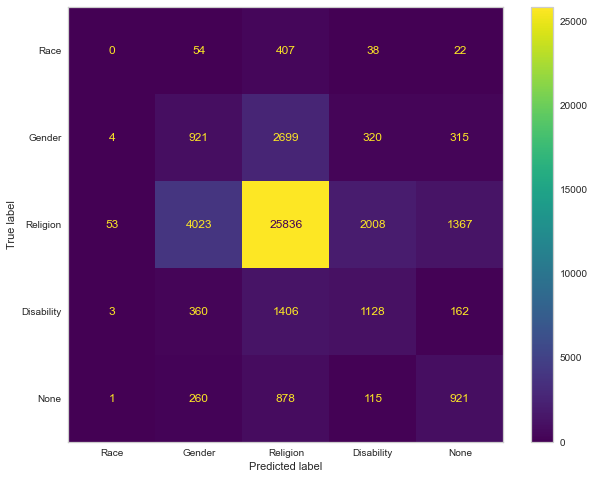

In [186]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred_3)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Race", "Gender", "Religion", "Disability", "None"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [199]:
y_test_2

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [196]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# from sklearn.metrics import roc_auc_score
# nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred_3)
# auc_score1 = roc_auc_score(y_test, y_pred_3)
# random_probs = [0 for i in range(len(y_test))]
# p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
# plt.style.use('seaborn')
# # plot roc curves
# plt.plot(nn_fpr_keras, nn_tpr_keras, linestyle='--',color='orange', label='Neural Network')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# # title
# plt.title('ROC curve')
# # x label
# plt.xlabel('False Positive Rate')
# # y label
# plt.ylabel('True Positive rate')

# plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
# plt.show();

C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


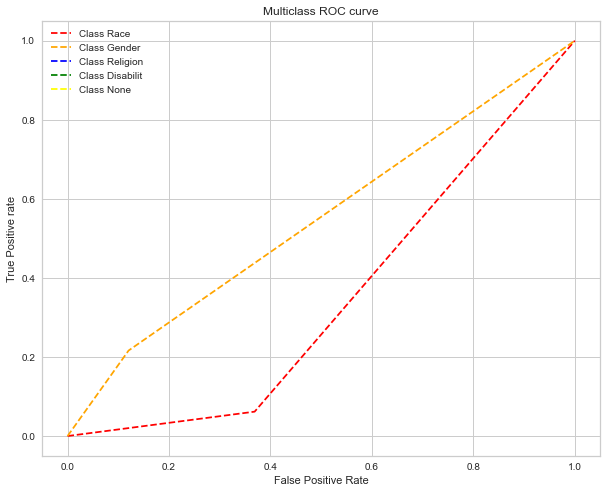

In [201]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# from sklearn.metrics import roc_auc_score
fpr = {}
tpr = {}
thresh ={}
n_class = ["Race", "Gender", "Religion", "Disability", "None"]
for i in range(len(n_class)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_2[:,i], y_pred_4[:,i], pos_label=i)
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Class Race ')
plt.plot(fpr[1], tpr[1], linestyle='--',color='orange', label='Class Gender')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Religion')
plt.plot(fpr[3], tpr[3], linestyle='--',color='green', label='Class Disabilit')
plt.plot(fpr[4], tpr[4], linestyle='--',color='yellow', label='Class None')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

# LDA (Task 2)

In [205]:
# pip install pyLDAvis

In [206]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

**LDA Pre-Processing**

In [207]:
def lda_preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(token)
    return result

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [208]:
lda_preprocessed_comments = toxic_only_train_shortlisted['preprocessed_text'].map(lda_preprocess)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Gensim**

In [209]:
dictionary = corpora.Dictionary(lda_preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [210]:
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [211]:
lda_model = models.LdaMulticore(corpus_tfidf, num_topics=20,
                                    id2word=dictionary, passes=2, workers=2)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [212]:
topics = lda_model.print_topics(num_words=5)
for i, topic in enumerate(topics[:10]):
    print("Train topic {}: {}".format(i, topic))

Train topic 0: (0, '0.006*"trump" + 0.005*"loser" + 0.004*"like" + 0.004*"people" + 0.004*"tweet"')
Train topic 1: (1, '0.009*"trump" + 0.007*"korea" + 0.006*"north" + 0.005*"war" + 0.004*"president"')
Train topic 2: (2, '0.014*"stupid" + 0.012*"ha" + 0.008*"dumb" + 0.007*"fool" + 0.005*"city"')
Train topic 3: (3, '0.014*"gun" + 0.008*"black" + 0.008*"kill" + 0.007*"people" + 0.007*"police"')
Train topic 4: (4, '0.011*"comment" + 0.009*"ridiculous" + 0.007*"stupid" + 0.007*"post" + 0.006*"kim"')
Train topic 5: (5, '0.030*"idiot" + 0.013*"disgusting" + 0.006*"hawaii" + 0.005*"thief" + 0.005*"ball"')
Train topic 6: (6, '0.011*"woman" + 0.010*"gay" + 0.008*"men" + 0.008*"sex" + 0.008*"sexual"')
Train topic 7: (7, '0.015*"nfl" + 0.009*"coward" + 0.008*"draft" + 0.006*"dumbest" + 0.006*"trump"')
Train topic 8: (8, '0.018*"moron" + 0.013*"mccain" + 0.013*"silly" + 0.012*"shut" + 0.011*"fake"')
Train topic 9: (9, '0.009*"black" + 0.008*"white" + 0.005*"people" + 0.004*"trump" + 0.004*"right"'

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [213]:
# predict the type of topic for document (index 5)

bd5 = bow_corpus[5]
for i in range(len(bd5)):
    print("Word {} (\"{}\") appears {} time.".format(bd5[i][0], dictionary[bd5[i][0]],bd5[i][1]))

Word 50 ("act") appears 1 time.
Word 51 ("bash") appears 1 time.
Word 52 ("christian") appears 1 time.
Word 53 ("entire") appears 1 time.
Word 54 ("idiot") appears 1 time.
Word 55 ("muslim") appears 1 time.
Word 56 ("okay") appears 2 time.
Word 57 ("religion") appears 1 time.
Word 58 ("sect") appears 1 time.
Word 59 ("smear") appears 1 time.


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [214]:
for index, score in sorted(lda_model[bd5], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.9208096861839294	 
Topic: 0.011*"woman" + 0.010*"gay" + 0.008*"men" + 0.008*"sex" + 0.008*"sexual"


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [215]:
# the lower the better
print('Perplexity: ', round(lda_model.log_perplexity(bow_corpus), 2))

# the higher the better
coherence_model_lda = models.CoherenceModel(model=lda_model, texts=lda_preprocessed_comments, 
                                     dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -9.22

Coherence Score:  0.40029190000890996


In [216]:
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
lda_vis

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\wei-d\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.072339 -0.004949       1        1  15.570476
6      0.086690 -0.013181       2        1   9.238332
15     0.074852 -0.007065       3        1   7.475795
0      0.040938 -0.021525       4        1   7.411034
3      0.098461  0.026022       5        1   6.883504
1      0.027248 -0.040301       6        1   5.976871
18     0.011330 -0.029571       7        1   5.691890
9      0.087921 -0.005855       8        1   5.674856
4     -0.012683 -0.025596       9        1   4.765866
19     0.001589 -0.036272      10        1   4.356663
2      0.029394  0.031887      11        1   4.097888
13    -0.027326 -0.051157      12        1   3.428336
17    -0.033562 -0.025835      13        1   3.276697
14    -0.022885 -0.032945      14        1   2.790775
7     -0.010515 -0.007614      15        1   2.665756
11    -0.065182 -0.009871      16        1   2.618714
10    -0.049654  0.002242      17        1   2.178289
12     0.044681  0.053575      18        1   2.176405
8     -0.256687 -0.089304      19        1   1.934733
5     -0.096952  0.287315      20        1   1.787121, topic_info=          Term         Freq         Total Category  logprob  loglift
54       idiot  7845.000000   7845.000000  Default  30.0000  30.0000
479      moron  4138.000000   4138.000000  Default  29.0000  29.0000
43      racist  6740.000000   6740.000000  Default  28.0000  28.0000
637        gun  4077.000000   4077.000000  Default  27.0000  27.0000
2761  canadian  3260.000000   3260.000000  Default  26.0000  26.0000
...        ...          ...           ...      ...      ...      ...
3009  marriage   160.673965    609.931633  Topic20  -5.8183   2.6906
2851    useful   159.735013    611.445570  Topic20  -5.8242   2.6823
465      trump   228.862765  14060.294849  Topic20  -5.4646  -0.0934
1088     horse   145.339802    433.085650  Topic20  -5.9186   2.9327
341       like   163.993835  11038.340412  Topic20  -5.7979  -0.1847

[1513 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4751      4  0.964746         aa
4848      5  0.949327  abhorrent
6402      8  0.942794     abject
2723      1  0.079551   abortion
2723      2  0.310014   abortion
...     ...       ...        ...
4950      8  0.011414        yup
4950      9  0.671124        yup
4950     10  0.047937        yup
4950     14  0.054786        yup
4950     18  0.034241        yup

[7435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 7, 16, 1, 4, 2, 19, 10, 5, 20, 3, 14, 18, 15, 8, 12, 11, 13, 9, 6])

In [231]:
lda_comments_joined = [" ". join(x) for x in list(lda_preprocessed_comments)]
# TFIDF numerical representation
tfidf_vectoriser = TfidfVectorizer()
lda_tfidf_vecs = tfidf_vectoriser.fit_transform(lda_comments_joined)

# Count numerical representation
count_vectoriser = CountVectorizer()
lda_count_vecs = count_vectoriser.fit_transform(lda_comments_joined)


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [224]:
vecs

C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<144334x72093 sparse matrix of type '<class 'numpy.int64'>'
	with 3254893 stored elements in Compressed Sparse Row format>

In [233]:
# find optimal k (no. of topics) and plot graph visually

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
model_topics = []

for num_topics in range(2, 14, 2):
    sg_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
    sg_lda_x.fit_transform(lda_tfidf_vecs)
    model_topics.append(num_topics)
    model_list.append(sg_lda_x)
    perplexity_values.append(sg_lda_x.perplexity(lda_tfidf_vecs))
    print("#Topics: " + str(num_topics) + ", Score: " + str(sg_lda_x.perplexity(lda_tfidf_vecs)))


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 2, Score: 11530.884999320759
#Topics: 4, Score: 16605.13788342132
#Topics: 6, Score: 21683.03973172857
#Topics: 8, Score: 24530.588163426964
#Topics: 10, Score: 29374.124006889877
#Topics: 12, Score: 32750.426010051026


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


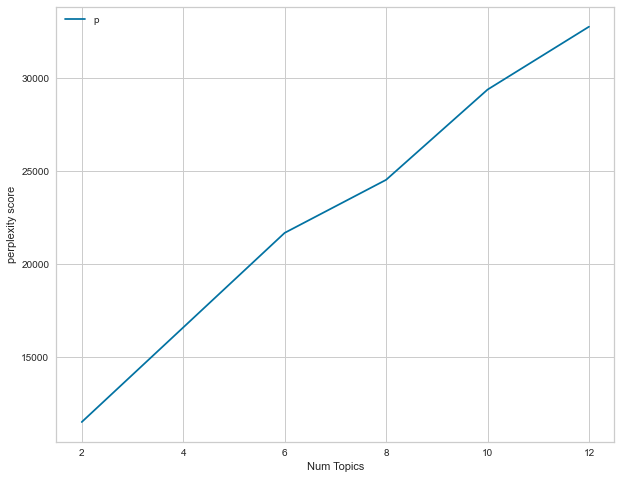

In [234]:
import matplotlib.pyplot as plt

limit=14; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [235]:

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
model_topics = []

for num_topics in range(2, 14, 2):
    sg_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
    sg_lda_x.fit_transform(lda_count_vecs)
    model_topics.append(num_topics)
    model_list.append(sg_lda_x)
    perplexity_values.append(sg_lda_x.perplexity(lda_count_vecs))
    print("#Topics: " + str(num_topics) + ", Score: " + str(sg_lda_x.perplexity(lda_count_vecs)))


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 2, Score: 4753.324094839882
#Topics: 4, Score: 4942.182387886553
#Topics: 6, Score: 5574.882141128069
#Topics: 8, Score: 5963.955978746704
#Topics: 10, Score: 6196.69407143136
#Topics: 12, Score: 6528.993434830794


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


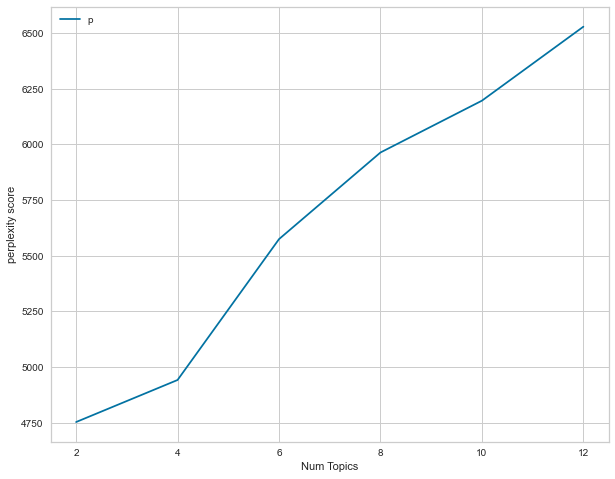

In [236]:
import matplotlib.pyplot as plt

limit=14; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

**Sklearn**

In [ ]:
lda_comments_joined = [" ". join(x) for x in list(lda_preprocessed_comments)]

In [15]:
# TFIDF numerical representation
tfidf_vectoriser = TfidfVectorizer()
lda_tfidf_vecs = tfidf_vectoriser.fit_transform(lda_comments_joined)

# Count numerical representation
count_vectoriser = CountVectorizer()
lda_count_vecs = count_vectoriser.fit_transform(lda_comments_joined)

In [16]:
# LDA based on TFIDF (use this first because of the similar TFIDF representation used for Gensim)

LDA_tfidf = LatentDirichletAllocation(n_jobs = -1)
LDA_tfidf.fit(lda_tfidf_vecs)

LatentDirichletAllocation(n_jobs=-1)

In [17]:
# LDA based on count

LDA_count = LatentDirichletAllocation(n_jobs = -1)
LDA_count.fit(lda_count_vecs)

LatentDirichletAllocation(n_jobs=-1)